# 数据预处理 

## 1.修改文件名 

In [1]:
import os

## 2.划分训练集和测试集 

In [2]:
import pandas as pd
import numpy as np

## 3.自定义数据集 

In [3]:
from PIL import Image
import torch.utils.data as data

In [4]:
'''
pytorch中的自定义数据集需要重写两个方法：
1.__getitem__(self, index) ———> 通过索引index获取image和label
2.__len__(self) ———> 返回数据集的长度
'''
class myDataset(data.Dataset):
    def __init__(self, path, fileName, transform=None):
        self.df = pd.read_csv(path+fileName, header=None)
        self.transform = transform
        self.path = path
    
    def __getitem__(self, index):
        label = self.df.loc[index].values[1]
        name = self.df.loc[index].values[0]
        img = Image.open(self.path + name)
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img, label
    
    def __len__(self):
        return self.df.shape[0]

In [5]:
dataset = myDataset('train/', 'train.csv')

In [6]:
img, label = dataset.__getitem__(0)

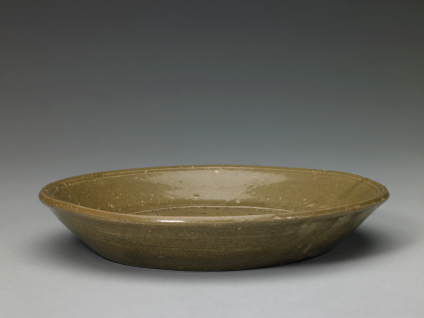

In [7]:
img

In [10]:
# 查看图像的模式
img.mode

'RGB'

In [8]:
label

0

In [9]:
dataset.__len__()

1548

# 定义模型 

In [10]:
import torch
from torchvision import models

In [103]:
# 使用了pytorch官方提供的预训练模型：AlexNet、VGG13、VGG16
# model = models.alexnet(pretrained=False)
model = models.vgg13_bn(pretrained=False)
# model = models.vgg16_bn(pretrained=False)

# 载入预训练模型
model.load_state_dict(torch.load('models/vgg13_bn-abd245e5.pth'))

<All keys matched successfully>

In [105]:
# 对网络的部分结构进行了fine-tune
model.classifier[3].out_features = 1024
model.classifier[6].in_features = 1024
model.classifier[6].out_features = 6
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Train the Model

## 1.DataLoader 

In [116]:
import torchvision.utils as utils
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch.utils.data as data

In [117]:
# define transform
# transform：a series operations on images

transform = T.Compose([
    T.Resize(256),                             # resize images to 256x256
    T.CenterCrop(224),                         # crop an 224x224 area in the center of the image 
    T.ToTensor(),                              # convert images to tensor type
    T.Normalize(mean=[0.485, 0.456, 0.406],    # normalization on images
                std=[0.229, 0.224, 0.225])
])

In [118]:
# define train dataset and validate dataset
train_dataset = myDataset('train/', 'train.csv', transform)
test_dataset = myDataset('val/', 'val.csv', transform)

In [119]:
# define train dataloader and validate dataloader
train_loader = data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=16, shuffle=True)

In [120]:
len(train_loader)
print(len(test_loader))

12


In [121]:
print(iter(train_loader))

In [122]:
# check the dataloader
imgs, labels = next(iter(train_loader))
print(imgs.shape)
print(labels.shape)
print(labels)

torch.Size([16, 3, 224, 224])
torch.Size([16])
tensor([4, 3, 3, 3, 2, 0, 0, 2, 1, 3, 0, 5, 3, 0, 2, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


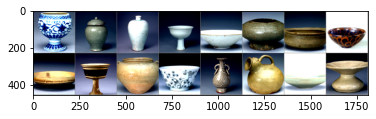

In [123]:
# visualize a batch od train dataset images

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(utils.make_grid(imgs))

## 2.train model 

In [124]:
import torch
import torch.nn as nn
import torch.optim as optim

In [125]:
# check if there is GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [126]:
# define parameters
epochs = 10        # train epochs
best_acc = 0.16    # best accuracy
loss_func = nn.CrossEntropyLoss()       # loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # parameters optimizer, we use Adam

model.to(device)   # deploy the model on device 

train_num = len(train_loader)    # length of train dataloader
test_num = len(test_loader)      # length of validate dataloader

In [127]:
for epoch in range(epochs):
    model.train()   # open the train mode
    for i, data in enumerate(train_loader):   # get data by batch， data = (imgs, labels)
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)   # deploy the data on device
        outputs = model(imgs)
        loss = loss_func(outputs, labels)     # caculate the loss between outputs and labels
        optimizer.zero_grad()                 # empty the gradient
        loss.backward()                       # back propagation
        optimizer.step()                      # update parameters
        # 打印输出信息
        print('Train Step: [{} / {}], Loss: {:.4f}'.format(i+1, train_num, loss.item()), end='\r', flush=True)
    
    model.eval()   # open the evaluate mode
    acc_num = 0    # record the number of true prediction
    acc = 0.0      # record the accuracy on validate dataset
    with torch.no_grad():
        for i, data in enumerate(test_loader): # get data by batch
            t_imgs, t_labels = data
            t_imgs, t_labels = t_imgs.to(device), t_labels.to(device)
            t_outputs = model(t_imgs)
            predicts = torch.max(t_outputs, dim=1)[1]   # find the class of the maximal probability one among predictions
            acc_num += torch.eq(predicts, t_labels).sum().item()
            print('Test Step: [{} / {}]'.format(i+1, test_num), end='\r', flush=True)
    
    acc = acc_num / len(test_dataset)
    print('Epoch: [{} / {}], Acc: {:.4f}, Acc_num: {}'.format(epoch+1, epochs, acc, acc_num))
    
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'models/VGG13_2.pth')

Epoch: [1 / 10], Acc: 0.9611, Acc_num: 173
Epoch: [2 / 10], Acc: 0.9778, Acc_num: 176
Epoch: [3 / 10], Acc: 0.9389, Acc_num: 169
Epoch: [4 / 10], Acc: 0.9778, Acc_num: 176
Epoch: [5 / 10], Acc: 0.9889, Acc_num: 178
Epoch: [6 / 10], Acc: 0.9722, Acc_num: 175
Epoch: [7 / 10], Acc: 0.9556, Acc_num: 172
Epoch: [8 / 10], Acc: 0.8944, Acc_num: 161
Epoch: [9 / 10], Acc: 0.9833, Acc_num: 177
Epoch: [10 / 10], Acc: 0.9833, Acc_num: 177
